In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from config import PATH, MODEL
from model.Mukara import Mukara
import json

def plot_cluster_assignments(sensor_id, mukara):
    """
    Plot the cluster assignments for origin (O) and destination (D) pixels as a rasterized map,
    zooming into the rectangular area containing the relevant grid cells.

    Args:
        sensor_id (str): Sensor identifier.
        mukara (Mukara): Instance of the Mukara model.
    """
    # Forward pass through the Mukara model to compute cluster assignments
    _, _, _, (o_cluster_assignments, d_cluster_assignments) = mukara(sensor_id)
    
    # Load grid cells
    from model.dataloader import load_grid_cells
    grid_cells = load_grid_cells()

    # Load cached indices for O and D regions
    cache_dir = os.path.join(PATH['cache'] + '_' + str(MODEL['embedding_dim']), sensor_id)
    index_path = os.path.join(cache_dir, "index.json")
    
    with open(index_path, 'r') as f:
        cache_data = json.load(f)
    o_indices = cache_data['o_indices']
    d_indices = cache_data['d_indices']
    
    # Get the cluster assignments (argmax for hard assignment)
    o_clusters = np.argmax(o_cluster_assignments.numpy(), axis=1)  # (N_o,)
    d_clusters = np.argmax(d_cluster_assignments.numpy(), axis=1)  # (N_d,)
    
    # Assign cluster IDs to the grid cells GeoDataFrame
    grid_cells['o_cluster'] = -1  # Initialize with -1 (no cluster)
    grid_cells['d_cluster'] = -1  # Initialize with -1 (no cluster)
    grid_cells.loc[o_indices, 'o_cluster'] = o_clusters
    grid_cells.loc[d_indices, 'd_cluster'] = d_clusters

    # Extract relevant grid cells for plotting
    o_grid_cells = grid_cells.loc[o_indices]
    d_grid_cells = grid_cells.loc[d_indices]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Origin clusters
    plt.subplot(1, 2, 1)
    # o_grid_cells.boundary.plot(color='gray', linewidth=0.5, ax=plt.gca())  # Plot grid boundaries
    o_grid_cells.plot(column='o_cluster', cmap='tab10', ax=plt.gca(), legend=True)
    plt.title(f"Origin Cluster Assignments (Sensor: {sensor_id})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(o_grid_cells.total_bounds[[0, 2]])  # Zoom to O grid cells
    plt.ylim(o_grid_cells.total_bounds[[1, 3]])  # Zoom to O grid cells
    
    # Destination clusters
    plt.subplot(1, 2, 2)
    # d_grid_cells.boundary.plot(color='gray', linewidth=0.5, ax=plt.gca())  # Plot grid boundaries
    d_grid_cells.plot(column='d_cluster', cmap='tab10', ax=plt.gca(), legend=True)
    plt.title(f"Destination Cluster Assignments (Sensor: {sensor_id})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(d_grid_cells.total_bounds[[0, 2]])  # Zoom to D grid cells
    plt.ylim(d_grid_cells.total_bounds[[1, 3]])  # Zoom to D grid cells
    
    plt.tight_layout()
    plt.show()

In [6]:
mukara = Mukara()
_, _, _, _ = mukara("2")
mukara.load_weights(os.path.join(PATH['param'], '20250206-162016.h5'))

Grid features shape (653, 573, 14)


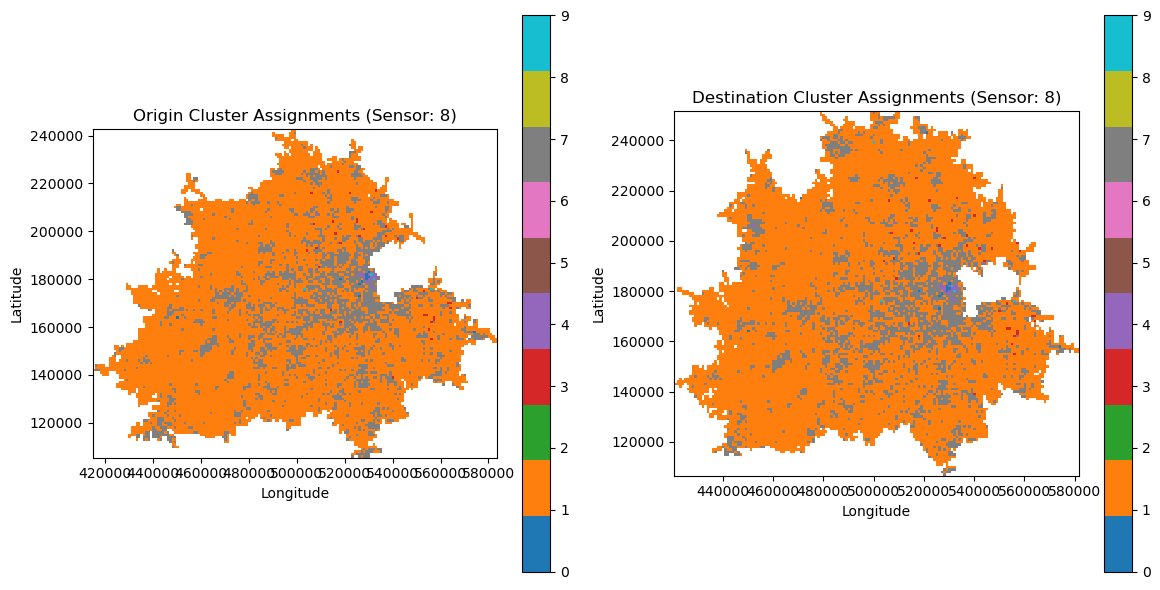

In [7]:
# Plot cluster assignments for the sensor
plot_cluster_assignments("8", mukara)